C:\Users\JACOB\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



--- Model Performance Comparison ---
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Logistic Regression     0.814      0.777   0.720     0.747
KNN                     0.796      0.743   0.713     0.728
Decision Tree           0.832      0.809   0.733     0.769
Naive Bayes             0.796      0.740   0.720     0.730


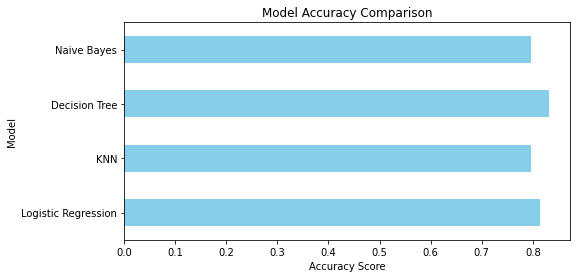

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix
)

# 1. Load Data
try:
    # Removing 'quiet' for compatibility with older sklearn versions
    titanic = fetch_openml("titanic", version=1, as_frame=True)
    df = titanic.frame
except Exception as e:
    print(f"Error loading data: {e}")

# Select features and target
features = ["pclass", "sex", "age", "fare", "sibsp", "parch"]
target = "survived"
df = df[features + [target]].copy()

# Fix target type (sometimes it's loaded as a category or object)
df[target] = df[target].astype(int)

# 2. Split Data (BEFORE imputation to prevent leakage)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Define Preprocessing Pipelines
numeric_features = ["age", "fare", "sibsp", "parch"]
categorical_features = ["sex", "pclass"]

# Numeric: Fill missing with median -> Scale
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: Fill missing with mode -> One Hot Encode
# sparse_output=False makes it compatible with GaussianNB
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_features),
        ("cat", cat_transformer, categorical_features)
    ]
)

# 4. Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Naive Bayes": GaussianNB()
}

# 5. Training and Evaluation Loop
comparison_list = []

for name, model in models.items():
    # Create a single unified pipeline for each model
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Fit and Predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }
    comparison_list.append(metrics)

# 6. Display Comparison Table
results_df = pd.DataFrame(comparison_list).set_index("Model")
print("\n--- Model Performance Comparison ---")
print(results_df.round(3))

# Optional: Visualize Accuracy
results_df['Accuracy'].plot(kind='barh', color='skyblue', figsize=(8, 4))
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy Score")
plt.show()